## ProjF2 - Data Exploration

Use this document as a template to provide some exploratory analysis of your data similar to the one in ProjC1. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [18]:
# uncomment the packages you want to install
!pip install nltk
!pip install pandas
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install wordcloud
!pip install scikit-learn
!pip install spacy

  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached MarkupSafe-2.1.5-cp311-cp311-macosx_10_9_universal2.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.4/488.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.1/781.1 kB 16.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.4 MB/s eta 0:00:00
Using cached Jinja2-3.1.3-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s

In [19]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import nltk
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

### 1. Load and Visualize Data

Let's start by loading your entire dataset or a sample if it is a larger dataset.

In [41]:
### YOUR CODE HERE
train_data = pd.read_csv("../Data/train.csv")

FileNotFoundError: [Errno 2] No such file or directory: '.../Data/train.csv'

Provide some visualization of the data. For example,
- If your data is time series, you can plot a sequence and the response or label.
- If tabular data, you can plot histograms of the data.
- If working with image recognition or segmentation, you can show an image and the corresponding output.
- If it is a video that you are processing, just show screenshots.
- If doing something with reinforcement learning, you can provide samples of the simulation environment used.

### 0. Preprocessing

#### 1 Drop Unnecessary Column (URI)

In [4]:
train_data = train_data[['article', 'highlights']]

In [5]:
train_data.head(5)

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


#### 2 Removal of Stopwords

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords data
# nltk.download('stopwords')
# import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/u7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/u7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 3 Removal of Punctuation 

In [10]:
# Function to preprocess text
def preprocess_text(text):
    # Get the set of English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Combine regex patterns and compile them
    pattern = re.compile(r'[^\w\s]|(\d+)')
    
    # Apply regex substitution
    text = pattern.sub('', text)
    
    # Standardize capitalization
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(filtered_words)

# Preprocess the 'article' column in train_data
train_data['processed_article'] = train_data['article'].apply(preprocess_text)

In [12]:
train_data['processed_article'].head(5)

0    associated press published est october updated...
1    cnn ralph mata internal affairs lieutenant mia...
2    drunk driver killed young woman headon crash c...
3    cnn breezy sweep pen president vladimir putin ...
4    fleetwood team still record sky bet league one...
Name: processed_article, dtype: object

### 1.1 Word Cloud

In [11]:
wordcloud_spam = WordCloud(background_color="white").generate(' '.join(train_data['processed_article']))


plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Inferno")
plt.axis("off")
plt.show()

KeyboardInterrupt: 

## 1.2 Explore Ngrams

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

#### Bi-grams

<Axes: >

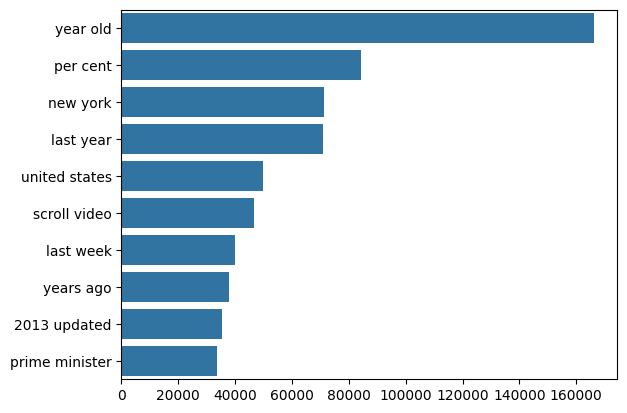

In [ ]:
top_n_bigrams=get_top_ngram(train_data['processed_article'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

### 2. Compute Some Statistics from your Data

First, extract some characterisitics about the input (e.g., image size, means and standard deviation of values, sample frequency).

### 2.1 Lemma Count

In [ ]:
sent_token = train_data['processed_article']

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize a dictionary to store unique lemmas and their counts
unique_lemma = {}

# Iterate through each sentence in the dataset
for sentence in sent_token:
    # Tokenize the sentence
    words = word_tokenize(sentence)
    # Lemmatize each word and count unique lemmas
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        if lemma not in unique_lemma:
            unique_lemma[lemma] = 1
        else:
            unique_lemma[lemma] += 1

# Print the number of unique lemmas
print(len(unique_lemma))

900566


### 2.2 POS Tagging Statistics

{'JJ': 279893, 'NNP': 6713, 'NN': 382, 'POS': 45, 'IN': 10, 'CD': 63, 'VBD': 4, 'MD': 2, 'VB': 1}


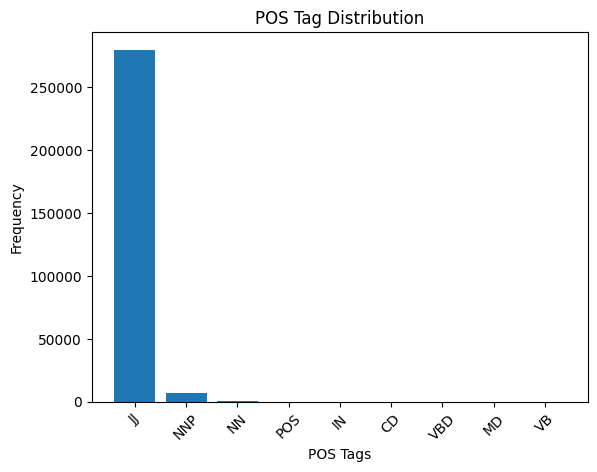

In [ ]:
pos_tagged = nltk.pos_tag(train_data['processed_article'])

# Initialize a dictionary to store POS tags and their counts
pos_dict = {}

# Count the occurrences of each POS tag
for word in pos_tagged:
    if word[-1] not in pos_dict:
        pos_dict[word[-1]] = 1
    else:
        num = pos_dict.get(word[-1])
        pos_dict[word[-1]] = num + 1

# Print the dictionary containing POS tags and their counts
print(pos_dict)

# Plotting barplot for POS tags
names = list(pos_dict.keys())
values = list(pos_dict.values())
plt.bar(range(len(pos_dict)), values, tick_label=names)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution')
plt.xticks(rotation=45)
plt.show()

## 2.5 TTR Ratio
Type Token Ratio

In [ ]:
types=nltk.Counter(train_data['processed_article'])
ttr=(len(types)/len(train_data['processed_article']))*100
print(ttr)

98.91471302239884


## 2.6 TF/IDF

In [9]:
corpus = train_data['processed_article']

# Create a TfidfVectorizer object and fit it to the preprocessed corpus
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

# Transform the preprocessed corpus into a TF-IDF matrix
tf_idf_matrix = vectorizer.transform(corpus)

# Get list of feature names that correspond to the columns in the TF-IDF matrix
words_set = vectorizer.get_feature_names_out()

# Finally, we'll create a dataframe to better show the TF-IDF scores of each document:
df_tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf_matrix, columns=words_set)
print(df_tf_idf)

        00       000  0000  000000000  000000004  000000006  00000001  \
0        0         0     0          0          0          0         0   
1        0         0     0          0          0          0         0   
2        0         0     0          0          0          0         0   
3        0         0     0          0          0          0         0   
4        0         0     0          0          0          0         0   
...     ..       ...   ...        ...        ...        ...       ...   
287108   0         0     0          0          0          0         0   
287109   0  0.015497     0          0          0          0         0   
287110   0         0     0          0          0          0         0   
287111   0  0.012009     0          0          0          0         0   
287112   0  0.023799     0          0          0          0         0   

        00000002  00000003  00000004  ...  ﬂeet  ﬂexible  ﬂight  ﬂights  ﬂirt  \
0              0         0         0  ... 

### 3. Inference and Comment on Your Data
Next, provide some characteristics about your output (e.g., histograms, spatial distribution of bounding boxes in the case of object detection, etc.). In the case of cases such as tasks such as reinforcement learning, you can provide details about the desired output and rewards used. You can show some correlations between inputs and outputs if possible.

Answer these questions as appropriate?
- Is your data balanced?
- Are there disparities in your input data? Does it show some specific patterns?
    1) Stopwords - The presence of stopwords can introduce noise in the data. After we implement stop words removal, we see significant differences in the frequency distribution of words indicating their presence.
    2) Part-of-Speech (POS) tagging - According to POS, adjectives and proper nouns have a very high frequency as compared to other POS tags such as verbs, conjunctions, modals. This indicates that certain linguistic or grammatical features are less common in the input text.
    3) Writing style - POS tagging suggest variations in laguage styles and contents. This may impact summarization model.
    4) Language and Vocabulary - The input data consists of news articles only in English language. Thus based on different publications, use of language and vocabulary changes. 

Here, we have two columns / attributes in our data. The "Article" attribute is the entire article in its original format and level of detail as published. The "Highlights" format has the highlights or the main summary of the corresponding article.
In our exploration, we are mainly exploring the article attribute.
First we have processed it by removing stopwords, tokenizing it, removing numbers and normalizing capitalization.

Then, we have visualized our article input data from a variety of angles, which we will talk about below.

## Explain each graph: Why we picked that graph/viz and what did we want to explore? What does the result tell us?

`### Comment here`
#### Is the data balanced?

Not exactly. From our POS tagging statistics, we see that the adjectives 'JJ' are the most frequent part-of-speech used in news articles.
